<a href="https://colab.research.google.com/github/ACSS-PSL/NLP_lectures_PSLWeek_python/blob/main/PSL_Week_RNN_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification with an RNN

This text classification trains a recurrent neural network (RNN) on the IMDB large movie review dataset for sentiment analysis.

## Setup

Before starting, it is interesting to check the capabilities we have in our server.

In [1]:
!nvidia-smi #This is the command to know the GPU info 

Sun Nov 20 23:09:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
cat /proc/meminfo # This is the command to know the RAM memory we have

MemTotal:       13297228 kB
MemFree:         8600808 kB
MemAvailable:   12387792 kB
Buffers:           88728 kB
Cached:          3810236 kB
SwapCached:            0 kB
Active:          1203676 kB
Inactive:        3240496 kB
Active(anon):       1056 kB
Inactive(anon):   469104 kB
Active(file):    1202620 kB
Inactive(file):  2771392 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1208 kB
Writeback:             0 kB
AnonPages:        545348 kB
Mapped:           309956 kB
Shmem:              1324 kB
KReclaimable:     108848 kB
Slab:             148324 kB
SReclaimable:     108848 kB
SUnreclaim:        39476 kB
KernelStack:        5808 kB
PageTables:         8688 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6648612 kB
Committed_AS:    3547964 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       50400 kB
VmallocChunk:          0 kB
Percpu:          

In [3]:
!lscpu #We can also check the CPU processor we have in our machine

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             2000.170
BogoMIPS:            4000.34
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_si

In [4]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

Import `matplotlib` and create a helper function to plot graphs:

In [5]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.


In [6]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [7]:
len(dataset['train'])

25000

In [8]:
len(dataset['test'])

25000

Initially this returns a dataset of (text, label) pairs:

In [9]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"This was so lame that I turned the DVD off...maybe halfway through. It was so weak, I couldn't even pay full enough attention to tell you how far in I made it.Though I really wanted to believe that the depiction of the young Carlito would be somewhat different, I just couldn't buy it. I don't really blame the actors, because I think it was the script that may have fallen flat. I did find myself laughing a few times, but I don't think those lines were intended to be funny.<br /><br />It's only saving grace is that I bought it in a 2 DVD set and I would have paid the price I did for the original alone. This is one of those cases when they should have let the classic stand alone."
 b'You remember the Spice Girls movie and how bad it was (besides the songs), well their manager Simon Fuller (also this band\'s manager) makes the same error putting S Club (another of my favourite bands) in their own film. S Club: Tina Barrett, Jon Lee, Bradley Mcintosh, Jo O\'Meara, Hannah Spearrit

## Create the text encoder

The raw text needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` function.

In [13]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens.

In [14]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

## Create the model


1. This model is built with `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.


The code to implement this is below:

In [15]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Compile the Keras model to configure the training process:

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [17]:
import os
checkpoint_path = "training_rnn/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [18]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [19]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30,
                    callbacks=[cp_callback])

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.6471 - accuracy: 0.5680
Epoch 1: saving model to training_rnn/cp.ckpt
391/391 [==============================] - 47s 91ms/step - loss: 0.6471 - accuracy: 0.5680 - val_loss: 0.5087 - val_accuracy: 0.7797
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.4151 - accuracy: 0.8038
Epoch 2: saving model to training_rnn/cp.ckpt
391/391 [==============================] - 35s 89ms/step - loss: 0.4151 - accuracy: 0.8038 - val_loss: 0.3689 - val_accuracy: 0.8411
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.8480
Epoch 3: saving model to training_rnn/cp.ckpt
391/391 [==============================] - 34s 87ms/step - loss: 0.3418 - accuracy: 0.8480 - val_loss: 0.3399 - val_accuracy: 0.8516
Epoch 4/10
391/391 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.8602
Epoch 4: saving model to training_rnn/cp.ckpt
391/391 [========================

In [20]:
# This comand is to download the trained model so we don't need to retrain each time we want to use it

#from google.colab import files
#os.system( "zip -r {} {}".format( 'training_rnn.zip' , 'training_rnn' ) )
#files.download('training_rnn.zip')

In [21]:
# If we execute this evaluation withouth training the model, is going to execute the default model
# The default model has no training so the accuracy is going to be low.

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 49ms/step - loss: 0.3141 - accuracy: 0.8618
Test Loss: 0.31409668922424316
Test Accuracy: 0.8617600202560425


In [22]:
#We can use this command to upload our trained model, or just click on the upload icon on the left upper corner.

#files.upload()

In [23]:
#!unzip training_rnn.zip

In [24]:
# Loads the weights
model.load_weights(checkpoint_path)

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 50ms/step - loss: 0.3141 - accuracy: 0.8618
Test Loss: 0.31409668922424316
Test Accuracy: 0.8617600202560425


(0.0, 0.6646199494600296)

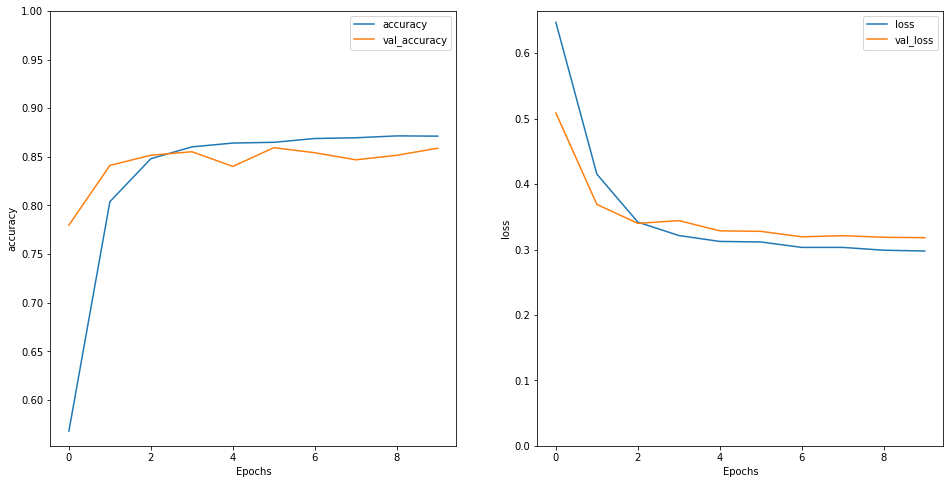

In [26]:
# These plots only works with the trained model during execution, as shows the evolution of the accuracy and loss in the differents epochs during training
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [32]:
sample_text = ('The movie was the worst. The animation and the graphics '
               'were out of this world. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 19ms/step
[[-1.8472258]]


In [33]:
sample_text = ('The movie was the best. The animation and the graphics '
               'were out of this world. I would highly recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 20ms/step
[[2.396447]]
